In [1]:
from selenium import webdriver

In [1]:
from datetime import datetime
from time import time
from lxml import html, etree

import requests, re
import os, sys
import unicodecsv as csv
import argparse
import json

In [ ]:
def parse(locality, checkin_date, checkout_date, sort):
    check_in = checkin_date.strftime("%Y/%m/%d")
    check_out = checkout_date.strftime("%Y/%m/%d")
    
    try:
        print('try',datetime.strptime(checkin_date,"%Y/%m/%d"))
    except:
        print('it was wrong')
        
    print("Scraper Initiated for Locality(: {}".format(locality))
    
    print("Finding search result page URL")
    geo_url = 'https://www.tripadvisor.com/TypeAheadJson?action=API&startTime='+str(int(time()))+'&uiOrigin=GEOSCOPE&source=GEOSCOPE&interleaved=true&types=geo,theme_park&neighborhood_geos=true&link_type=hotel&details=true&max=12&injectNeighborhoods=true&query='+locality
    api_response  = requests.get(geo_url, verify=False).json()
    url_from_autocomplete = "http://www.tripadvisor.com"+api_response['results'][0]['url']
    print('URL found {}'.format(url_from_autocomplete))
    geo = api_response['results'][0]['value'] 
    
    date = check_in+"_"+check_out
    
    form_data = {'changeSet': 'TRAVEL_INFO',
            'showSnippets': 'false',
            'staydates':date,
            'uguests': '2',
            'sortOrder':sort
    
                }
    
    headers = {
                            'Accept': 'text/javascript, text/html, application/xml, text/xml, */*',
                            'Accept-Encoding': 'gzip,deflate',
                            'Accept-Language': 'en-US,en;q=0.5',
                            'Cache-Control': 'no-cache',
                            'Connection': 'keep-alive',
                            'Content-Type': 'application/x-www-form-urlencoded; charset=utf-8',
                            'Host': 'www.tripadvisor.com',
                            'Pragma': 'no-cache',
                            'Referer': url_from_autocomplete,
                            'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:28.0) Gecko/20100101 Firefox/28.0',
                            'X-Requested-With': 'XMLHttpRequest'
                        }
    
    cookies=  {"SetCurrency":"USD"}
    print("Downloading search results page")
    page_response  = requests.post(url = url_from_autocomplete,data=form_data,headers = headers, cookies = cookies, verify=False)
    print("Parsing results ")
    parser = html.fromstring(page_response.text)
    hotel_lists = parser.xpath('//div[contains(@class,"listItem")]//div[contains(@class,"listing collapsed")]')
    
    hotel_data = []
    if not hotel_lists:
        hotel_lists = parser.xpath('//div[contains(@class,"listItem")]//div[@class="listing "]')

    for hotel in hotel_lists:
        XPATH_HOTEL_LINK = './/a[contains(@class,"property_title")]/@href'
        XPATH_REVIEWS  = './/a[@class="review_count"]//text()'
        XPATH_RANK = './/div[@class="popRanking"]//text()'
        XPATH_RATING = './/span[contains(@class,"rating")]/@alt'
        XPATH_HOTEL_NAME = './/a[contains(@class,"property_title")]//text()'
        XPATH_HOTEL_FEATURES = './/div[contains(@class,"common_hotel_icons_list")]//li//text()'
        XPATH_HOTEL_PRICE = './/div[contains(@data-sizegroup,"mini-meta-price")]/text()'
        XPATH_VIEW_DEALS = './/div[contains(@data-ajax-preserve,"viewDeals")]//text()' 
        XPATH_BOOKING_PROVIDER = './/div[contains(@data-sizegroup,"mini-meta-provider")]//text()'

        raw_booking_provider = hotel.xpath(XPATH_BOOKING_PROVIDER)
        raw_no_of_deals =  hotel.xpath(XPATH_VIEW_DEALS)
        raw_hotel_link = hotel.xpath(XPATH_HOTEL_LINK)
        raw_no_of_reviews = hotel.xpath(XPATH_REVIEWS)
        raw_rank = hotel.xpath(XPATH_RANK)
        raw_rating = hotel.xpath(XPATH_RATING)
        raw_hotel_name = hotel.xpath(XPATH_HOTEL_NAME)
        raw_hotel_features = hotel.xpath(XPATH_HOTEL_FEATURES)
        raw_hotel_price_per_night  = hotel.xpath(XPATH_HOTEL_PRICE)

        url = 'http://www.tripadvisor.com'+raw_hotel_link[0] if raw_hotel_link else  None
        reviews = ''.join(raw_no_of_reviews).replace("reviews","").replace(",","") if raw_no_of_reviews else 0 
        rank = ''.join(raw_rank) if raw_rank else None
        rating = ''.join(raw_rating).replace('of 5 bubbles','').strip() if raw_rating else None
        name = ''.join(raw_hotel_name).strip() if raw_hotel_name else None
        hotel_features = ','.join(raw_hotel_features)
        price_per_night = ''.join(str(*raw_hotel_price_per_night)).replace('\n','') if raw_hotel_price_per_night else None
        no_of_deals = re.findall("all\s+?(\d+)\s+?",''.join(raw_no_of_deals))
        booking_provider = ''.join(raw_booking_provider).strip() if raw_booking_provider else None

        if no_of_deals:
            no_of_deals = no_of_deals[0]
        else:
            no_of_deals = 0
            
        data = {
                    'hotel_name':name,
                    'url':url,
                    'locality':locality,
                    'reviews':reviews,
                    'tripadvisor_rating':rating,
                    'check_out':check_out,
                    'check_in':check_in,
                    'hotel_features':hotel_features,
                    'price_per_night':price_per_night,
                    'no_of_deals':no_of_deals,
                    'booking_provider':booking_provider

        }
        hotel_data.append(data)
    return hotel_data


In [ ]:
test_data = parse("New York", '2019/07/01', '2019/07/15', 'popularity')


In [ ]:
test_data[0]

In [ ]:
with open('tripadvisor_data.csv','wb')as csvfile:
            fieldnames = ['hotel_name','url','locality','reviews','tripadvisor_rating','check_in','check_out','price_per_night','booking_provider','no_of_deals','hotel_features']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for row in test_data:
                writer.writerow(row)


In [2]:
import pandas as pd

In [4]:
tadata = pd.read_csv('tripadvisor_data.csv')
tadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8389 entries, 0 to 8388
Data columns (total 9 columns):
hotel_name            8389 non-null object
url                   8389 non-null object
locality              8389 non-null object
reviews               8389 non-null object
tripadvisor_rating    8372 non-null float64
price_per_night       8385 non-null object
booking_provider      8386 non-null object
no_of_deals           8389 non-null int64
hotel_features        8183 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 589.9+ KB


In [5]:
tadatatest = tadata.drop_duplicates()
tadatatest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8389 entries, 0 to 8388
Data columns (total 9 columns):
hotel_name            8389 non-null object
url                   8389 non-null object
locality              8389 non-null object
reviews               8389 non-null object
tripadvisor_rating    8372 non-null float64
price_per_night       8385 non-null object
booking_provider      8386 non-null object
no_of_deals           8389 non-null int64
hotel_features        8183 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 655.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8389 entries, 0 to 8388
Data columns (total 9 columns):
hotel_name            8389 non-null object
url                   8389 non-null object
locality              8389 non-null object
reviews               8389 non-null object
tripadvisor_rating    8372 non-null float64
price_per_night       8385 non-null object
booking_provider      8386 non-null object
no_of_deals           8389 non-null

In [ ]:
tadatatest.to_csv("output_filename.csv", index=False, encoding='utf8')

In [6]:
tadata['url'][8241]

'http://www.tripadvisor.com/Hotel_Review-g186605-d321255-Reviews-Jurys_Inn_Dublin_Parnell_Street-Dublin_County_Dublin.html'

In [ ]:
driver.get('https://www.tripadvisor.com/Hotels-g186338-London_England-Hotels.html')
elems = driver.find_elements_by_class_name("ui_bubble_rating")
for e in elems:
    print(e.get_attribute("alt"))

In [ ]:
driver.get('https://www.tripadvisor.com/Hotels-g186338-London_England-Hotels.html')
elems = driver.find_elements_by_class_name("ui_bubble_rating")
for e in elems:
    print(e.get_attribute("alt"))

In [ ]:
# options = webdriver.ChromeOptions()
# options.add_argument('--ignore-certificate-errors')
# options.add_argument("--test-type")
# driver = webdriver.Chrome(chrome_options=options)
# driver.get('http://www.tripadvisor.com')
# time.sleep(3)
# python_button = driver.find_element_by_class_name("brand-quick-links-QuickLinkTileItem__link--1k5lE")
# python_button.click()
# text_area = driver.find_element_by_class_name('input-text-input-ManagedTextInput__managedInput--2RESp')
# text_area.send_keys("London, England")
# python_button = driver.find_element_by_class_name("common-typeahead-results-BasicResult__resultTitle--1TQbu")
# python_button.click()
# python_button = driver.find_element_by_class_name("pageNumbers")
# driver.find_element_by_class_name("pageNum taLnk ")
# elements = driver.find_element_by_xpath("//div[@class='pageNumbers']") get to next page
# elements.find_element_by_xpath("//*[@class='pageNum first taLnk ']")
# elements.click()
page_response = driver.page_source
parser = html.fromstring(page_response)
hotel_lists = parser.xpath('//div[contains(@class,"listItem")]//div[contains(@class,"listing collapsed")]')
hotel_data = []
if not hotel_lists:
    hotel_lists = parser.xpath('//div[contains(@class,"listItem")]//div[@class="listing "]')

for index, hotel in enumerate(hotel_lists):
    XPATH_HOTEL_LINK = './/a[contains(@class,"property_title")]/@href'
    XPATH_REVIEWS  = './/a[@class="review_count"]//text()'
    XPATH_RANK = './/div[@class="popRanking"]//text()'
    XPATH_RATING = './/a[contains(@class,"ui_bubble_rating")]//@alt'
    XPATH_HOTEL_NAME = './/a[contains(@class,"property_title")]//text()'
    XPATH_HOTEL_FEATURES = './/div[contains(@class,"common_hotel_icons_list")]//li//text()'
    XPATH_HOTEL_PRICE = './/div[contains(@data-sizegroup,"mini-meta-price")]/text()'
    XPATH_VIEW_DEALS = './/div[contains(@data-ajax-preserve,"viewDeals")]//text()' 
    XPATH_BOOKING_PROVIDER = './/div[contains(@data-sizegroup,"mini-meta-provider")]//text()'

    raw_booking_provider = hotel.xpath(XPATH_BOOKING_PROVIDER)
    raw_no_of_deals =  hotel.xpath(XPATH_VIEW_DEALS)
    raw_hotel_link = hotel.xpath(XPATH_HOTEL_LINK)
    raw_no_of_reviews = hotel.xpath(XPATH_REVIEWS)
    raw_rank = hotel.xpath(XPATH_RANK)
    raw_rating = hotel.xpath(XPATH_RATING)
    raw_hotel_name = hotel.xpath(XPATH_HOTEL_NAME)
    raw_hotel_features = hotel.xpath(XPATH_HOTEL_FEATURES)
    raw_hotel_price_per_night  = hotel.xpath(XPATH_HOTEL_PRICE)
    
    url = 'http://www.tripadvisor.com'+raw_hotel_link[0] if raw_hotel_link else  None
    reviews = ''.join(raw_no_of_reviews).replace("reviews","").replace(",","") if raw_no_of_reviews else 0 
    rank = ''.join(raw_rank) if raw_rank else None
    rating = ''.join(raw_rating).replace('of 5 bubbles','').strip() if raw_rating else None
    name = ''.join(raw_hotel_name).strip() if raw_hotel_name else None
    hotel_features = ','.join(raw_hotel_features)
    price_per_night = ''.join(str(*raw_hotel_price_per_night)).replace('\n','') if raw_hotel_price_per_night else None
    no_of_deals = re.findall("all\s+?(\d+)\s+?",''.join(raw_no_of_deals))
    booking_provider = ''.join(raw_booking_provider).strip() if raw_booking_provider else None

    if no_of_deals:
        no_of_deals = no_of_deals[0]
    else:
        no_of_deals = 0
            
    data = {
                'hotel_name':name,
                'url':url,
                'locality':'Brussels, Belgium',
                'reviews':reviews,
                'tripadvisor_rating':rating,
                'hotel_features':hotel_features,
                'price_per_night':price_per_night,
                'no_of_deals':no_of_deals,
                'booking_provider':booking_provider

            }
    hotel_data.append(data)    

In [32]:
with open('tripadvisor_data.csv','wb')as csvfile:
            fieldnames = ['hotel_name','url','locality','reviews','tripadvisor_rating','price_per_night','booking_provider','no_of_deals','hotel_features']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for row in hotel_data:
                writer.writerow(row)

AttributeError: 'str' object has no attribute 'keys'

In [ ]:
hotel_data[-1]

In [ ]:
driver.get('https://www.tripadvisor.com/Hotels-g188644-oa30-Brussels-Hotels.html')

In [ ]:
page_response = driver.page_source
parser = html.fromstring(page_response)
hotel_lists = parser.xpath('//div[contains(@class,"listItem")]//div[contains(@class,"listing collapsed")]')
hotel_data = []
if not hotel_lists:
    hotel_lists = parser.xpath('//div[contains(@class,"listItem")]//div[@class="listing "]')

for index, hotel in enumerate(hotel_lists):
    XPATH_HOTEL_LINK = './/a[contains(@class,"property_title")]/@href'
    XPATH_REVIEWS  = './/a[@class="review_count"]//text()'
    XPATH_RANK = './/div[@class="popRanking"]//text()'
    XPATH_RATING = './/a[contains(@class,"ui_bubble_rating")]//@alt'
    XPATH_HOTEL_NAME = './/a[contains(@class,"property_title")]//text()'
    XPATH_HOTEL_FEATURES = './/div[contains(@class,"common_hotel_icons_list")]//li//text()'
    XPATH_HOTEL_PRICE = './/div[contains(@data-sizegroup,"mini-meta-price")]/text()'
    XPATH_VIEW_DEALS = './/div[contains(@data-ajax-preserve,"viewDeals")]//text()' 
    XPATH_BOOKING_PROVIDER = './/div[contains(@data-sizegroup,"mini-meta-provider")]//text()'

    raw_booking_provider = hotel.xpath(XPATH_BOOKING_PROVIDER)
    raw_no_of_deals =  hotel.xpath(XPATH_VIEW_DEALS)
    raw_hotel_link = hotel.xpath(XPATH_HOTEL_LINK)
    raw_no_of_reviews = hotel.xpath(XPATH_REVIEWS)
    raw_rank = hotel.xpath(XPATH_RANK)
    raw_rating = hotel.xpath(XPATH_RATING)
    raw_hotel_name = hotel.xpath(XPATH_HOTEL_NAME)
    raw_hotel_features = hotel.xpath(XPATH_HOTEL_FEATURES)
    raw_hotel_price_per_night  = hotel.xpath(XPATH_HOTEL_PRICE)
    
    url = 'http://www.tripadvisor.com'+raw_hotel_link[0] if raw_hotel_link else  None
    reviews = ''.join(raw_no_of_reviews).replace("reviews","").replace(",","") if raw_no_of_reviews else 0 
    rank = ''.join(raw_rank) if raw_rank else None
    rating = ''.join(raw_rating).replace('of 5 bubbles','').strip() if raw_rating else None
    name = ''.join(raw_hotel_name).strip() if raw_hotel_name else None
    hotel_features = ','.join(raw_hotel_features)
    price_per_night = ''.join(str(*raw_hotel_price_per_night)).replace('\n','') if raw_hotel_price_per_night else None
    no_of_deals = re.findall("all\s+?(\d+)\s+?",''.join(raw_no_of_deals))
    booking_provider = ''.join(raw_booking_provider).strip() if raw_booking_provider else None

    if no_of_deals:
        no_of_deals = no_of_deals[0]
    else:
        no_of_deals = 0
            
    data = {
                'hotel_name':name,
                'url':url,
                'locality':'Dublin, Ireland',
                'reviews':reviews,
                'tripadvisor_rating':rating,
                'hotel_features':hotel_features,
                'price_per_night':price_per_night,
                'no_of_deals':no_of_deals,
                'booking_provider':booking_provider

            }
    hotel_data.append(data)    

In [ ]:
with open('tripadvisor_data.csv','ab')as csvfile:
            fieldnames = ['hotel_name','url','locality','reviews','tripadvisor_rating','price_per_night','booking_provider','no_of_deals','hotel_features']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            for row in hotel_data:
                writer.writerow(row)

In [158]:
import json
from collections import OrderedDict

In [ ]:
def clean(text):
    if text:
        # Removing \n \r and \t
        return ' '.join(''.join(text).split()).strip()
    return None

In [53]:
def process_request(myurl, retry=0):
    
        MAX_RETRY = 10
        RETRY = 0

        headers = {
                    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
                    "accept-encoding": "gzip, deflate, br",
                    "accept-language": "en-GB,en;q=0.9,en-US;q=0.8,ml;q=0.7",
                    "cache-control": "max-age=0",
                    "upgrade-insecure-requests": "1",
                    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/71.0.3578.80 Chrome/71.0.3578.80 Safari/537.36",
                }
        
        response = requests.get(myurl, headers=headers)
        if response.status_code == 404:
            print('error: Page not found, status_code: 404')

        parser = html.fromstring(response.text, myurl)

        script_text = ' '.join(''.join(parser.xpath('//script//text()')).split())
        raw_json = re.findall("define\(\'@ta\/page\-manifest\'\,\[\]\,function\(\)\{return\s+({.*?});\}\);", script_text)
        try:
            json_loaded = json.loads(raw_json[0])
        except Exception as e:
            json_loaded = {}
            if RETRY < MAX_RETRY:
                RETRY = RETRY+1
                # Retrying the same URL
                process_request(myurl, RETRY)

        XPATH_NAME = '//h1[@id="HEADING"]//text()'
        XPATH_RANK = '//span[contains(@class,"popularity")]//text()'
    #     XPATH_AMENITIES = "//div[contains(text(),'HOTEL FEATURES')]/following-sibling::div//div[@class='textitem']//text()"
#         XPATH_HIGHLIGHTS = '//div[contains(@class,"HighlightedAmenities__amenityItem")]/text()'
#         XPATH_OFFICIAL_DESCRIPTION = '//div[contains(text(),"Description")]/following-sibling::div//span[contains(@class,"introText")]/text()'
#         XPATH_ADDITIONAL_INFO = "//div[@class='section_content']//div[@class='sub_title']"
        XPATH_FULL_ADDRESS_JSON = '//script[@type="application/ld+json"]//text()'

        raw_name = parser.xpath(XPATH_NAME)
        raw_rank = parser.xpath(XPATH_RANK)
    #     amenities = parser.xpath(XPATH_AMENITIES)
#         raw_highlights = parser.xpath(XPATH_HIGHLIGHTS)
#         raw_official_description = parser.xpath(XPATH_OFFICIAL_DESCRIPTION)
#         raw_additional_info = parser.xpath(XPATH_ADDITIONAL_INFO)
        raw_address_json = parser.xpath(XPATH_FULL_ADDRESS_JSON)
        name = clean(raw_name)
        rank = clean(raw_rank)
        if not name:
            if RETRY < MAX_RETRY:
                RETRY = RETRY+1
                # Retrying the same URL
                process_request(myurl, RETRY)
#         official_description = clean(raw_official_description)
#         cleaned_highlights = filter(lambda x: x != '\n', raw_highlights)
        hotel_rating = 0
        review_count = 0
        address = {}
        if raw_address_json:
            try:
                parsed_address_info = json.loads(raw_address_json[0])
                rating = parsed_address_info.get('aggregateRating', {})
                address = parsed_address_info.get("address", {})

                hotel_rating = rating.get('ratingValue')
                review_count = rating.get('reviewCount')

                address = {
                            'street_address': address.get('streetAddress'),
                            'region': address.get('addressRegion'),
                            'locality': address.get('addressLocality'),
                            'country': address.get("addressCountry", {}).get("name"),
                            'zipcode': address.get("postalCode")
                }
            except Exception as e:
                review_count = hotel_rating = 0
                raise e
#         highlights = ','.join(cleaned_highlights).replace('\n', '')

    #     if json_loaded:
    #         redux_response = json_loaded['redux']['api']['responses']
    #         if redux_response:
    #             for url_ in redux_response.keys():
    #                 if '/data/1.0/location/' in url_:
    #                     rating_histogram = redux_response.get(url_).get('data').get('rating_histogram', {})
        ratings = {}
        elems = parser.find_class("hotels-review-list-parts-ReviewRatingFilter__row_num--gIW_f")
        if elems:
            ratings = {
                'Excellent': elems[0].text,
                'Good': elems[1].text,
                'Average': elems[2].text,
                'Poor': elems[3].text,
                'Terrible': elems[4].text
                }

        amenities = parser.find_class("hotels-hotel-review-about-with-photos-Amenity__name--2IUMR")
        amenity_list = []     # {'Hotel Amenities': ','.join(amenities.text)}
        for a in amenities:
            amenity_list.append(a.text)
#         additional_info_dict = OrderedDict()
#         for info in raw_additional_info:
#             XPATH_INFO_TEXT = ".//text()"

#             if info.xpath(XPATH_INFO_TEXT):
#                 XPATH_INFO_KEY = ".//text()"
#                 XPATH_INFO_VALUE = './/following-sibling::div[@class="sub_content"][1]//text()'

#                 raw_info_key = info.xpath(XPATH_INFO_KEY)
#                 raw_info_value = info.xpath(XPATH_INFO_VALUE)
#                 if raw_info_value and raw_info_key:
#                     # cleaning
#                     raw_info_value = clean(raw_info_value)
#                     # contact information such as website and email address are encoded by tripadvisor
#                     if not raw_info_key[0] == 'Contact Information':
#                         additional_info_dict.update({raw_info_key[0]: raw_info_value})

        data = {
                'address': address,
                'ratings': ratings,
                'amenities': amenity_list,
#                 'official_description': official_description,
#                 'additional_info': additional_info_dict,
                'rating': float(hotel_rating) if hotel_rating else 0.0,
                'review_count': int(review_count) if review_count else 0,
                'name': name,
                'rank': rank,
#                 'highlights': highlights,
                'hotel_url': myurl
        }
        
        return data


In [ ]:
process_request(tadata['url'][8250])

In [ ]:
amenities = parser.find_class("hotels-hotel-review-about-with-photos-Amenity__name--2IUMR")
testlist = []
for a in amenities:
    testlist.append(a.text)
testlist

In [4]:
import time as t
import smtplib, ssl

In [7]:
import random

In [ ]:
# details = 0 

In [ ]:
hotel_details = []
for hotel in tadata['url'][8241:8300]:
    result = process_request(hotel)
    hotel_details.append(result)
    large = random.randint(1, 3)
    small = random.randint(1, 9)/10
    timeout = large + small
    print(timeout)
    t.sleep(timeout)

In [ ]:
hotel_details[-1]

In [ ]:
len(hotel_details)

In [ ]:
details.extend(hotel_details)
len(details)

In [ ]:
detail1 = details[:8238]

In [ ]:
detail1[-1]

In [ ]:
with open('tripadvisor_hotel.txt', 'w') as out_file:
    json.dump(detail1, out_file)

In [8]:
with open('tripadvisor_hotel.txt', 'r') as json_file:  
    tahotel = json.loads(json_file.read())

In [15]:
tahotel[0]

{'address': {'street_address': '15 Montague Street',
  'region': '',
  'locality': 'London',
  'country': 'United Kingdom',
  'zipcode': 'WC1B 5BJ'},
 'ratings': {'Excellent': '3,984',
  'Good': '691',
  'Average': '109',
  'Poor': '26',
  'Terrible': '11'},
 'amenities': ['Room service',
  'Restaurant',
  'Free High Speed Internet (WiFi)',
  'Bar/Lounge',
  'Fitness Center with Gym / Workout Room',
  'Airport transportation',
  'Babysitting',
  'Banquet Room',
  'Business Center with Internet Access',
  'Concierge',
  'Conference Facilities',
  'Dry Cleaning',
  'Laundry Service',
  'Meeting rooms',
  'Multilingual Staff',
  'Non-smoking hotel',
  'Pets Allowed ( Dog / Pet Friendly )',
  'Wheelchair access',
  'Air conditioning',
  'Non-smoking rooms',
  'Suites'],
 'rating': 5.0,
 'review_count': 4821,
 'name': 'The Montague on The Gardens',
 'rank': '#5 of 1,116 Hotels in London',
 'hotel_url': 'http://www.tripadvisor.com/Hotel_Review-g186338-d192036-Reviews-The_Montague_on_The_Gard

In [5]:
from bs4 import BeautifulSoup
import urllib

In [10]:
hotel_url = tahotel[0]['hotel_url']
num_reviews = tahotel[0]['review_count']

In [25]:
reviewer_list = pd.DataFrame(columns=['uid', 'user_link', 'rating', 'date_of_stay', 'num_of_reviews'])
reviewer_list = reviewer_list.append({'uid':'JIT66', 'user_link':'http://www.tripadvisor.com/Profile/JIT66', 'rating':5, 'date_of_stay':'April 2019', 'num_of_reviews':55}, ignore_index=True)
reviewer_list.head()

,uid,user_link,rating,date_of_stay,num_of_reviews
0,JIT66,http://www.tripadvisor.com/Profile/JIT66,5,April 2019,55


In [150]:
response = requests.get(hotel_url)
if response.status_code == 404:
    print('error: Page, '+ hotel_url +' is not found, status_code: 404')
soup = BeautifulSoup(response.text)
reviews = soup.findAll(class_ = 'hotels-review-list-parts-SingleReview__reviewContainer--d54T4')
review_count = 30
if num_reviews < 100:
    pass
else:
    next_page = soup.find('a', class_="ui_button nav next primary ", href=True)
    try:
        next_page = 'http://www.tripadvisor.com'+next_page['href']
    except:
        print('Last Page')
    print(next_page)
    for r in reviews:
        try:
            contribute = r.find('span', class_ = 'social-member-MemberHeaderStats__bold--3z3qh').get_text()
        except AttributeError:
            print('One reviewer has no reviews.')
            pass
        if int(contribute) > 10:
            reviewer = r.find('a', class_ = 'ui_header_link social-member-event-MemberEventOnObjectBlock__member--35-jC').get_text()
            reviewer_website = r.find('a', href=True)
            reviewer_website = 'http://www.tripadvisor.com'+reviewer_website['href']
            rating = r.find('span', class_="ui_bubble_rating")
            rating = str(rating).strip('"0></span>')[-1:]
            date =  r.find(class_ = 'hotels-review-list-parts-EventDate__event_date--CRXs4').find('span').get_text()
            print(reviewer + ': ', reviewer_website + ', ', rating + ': ', date[14:] + '; ', contribute)
            
    

http://www.tripadvisor.com/Hotel_Review-g186338-d192036-Reviews-or10-The_Montague_on_The_Gardens-London_England.html
livinglifetothefull1:  http://www.tripadvisor.com/Profile/livinglifetothefull1,  5:  April 2019;  659


In [120]:
response

<Response [200]>

In [226]:
import pdb

In [71]:
reviewer_list = pd.DataFrame(columns=['uid', 'user_link', 'rating', 'date_of_stay', 'num_of_reviews'])
reviewer_list = reviewer_list.append({'uid':'JIT66', 'user_link':'http://www.tripadvisor.com/Profile/JIT66', 'rating':5, 'date_of_stay':'April 2019', 'num_of_reviews':55}, ignore_index=True)
reviewer_list.head()

,uid,user_link,rating,date_of_stay,num_of_reviews
0,JIT66,http://www.tripadvisor.com/Profile/JIT66,5,April 2019,55


In [167]:
def process_reviews(hotel_url, reviewer_list):
    response = requests.get(hotel_url)
    if response.status_code != 200:
        print('error: On page, '+ hotel_url +' is found.')
        return reviewer_list
    else:
        soup = BeautifulSoup(response.text)
        reviews = soup.findAll(class_ = 'hotels-review-list-parts-SingleReview__reviewContainer--d54T4')
        review_count = 10
        reviewer_list = iterate_review_page(soup, reviews, review_count, reviewer_list)
        return reviewer_list
            
def iterate_review_page(soup, reviews, review_count, reviewer_list):           

    next_page = soup.find('a', class_="ui_button nav next primary ", href=True)
    try:
        next_page = 'http://www.tripadvisor.com'+next_page['href']
    except:
        print('Last Page')
        
    for r in reviews:
        try:
            contribute = r.find('span', class_ = 'social-member-MemberHeaderStats__bold--3z3qh').get_text()
            if ',' in contribute:
                contribute = contribute.replace(',', '')
        except AttributeError:
            contribute = 0
            pass
        if int(contribute) > 25 and review_count > 0:
            try:
                reviewer = r.find('a', class_ = 'ui_header_link social-member-event-MemberEventOnObjectBlock__member--35-jC').get_text()
            except AttributeError:
                reviewer = "NONE PROVIDED"
                
            reviewer_website = r.find('a', href=True)
            reviewer_website = 'http://www.tripadvisor.com'+reviewer_website['href']
            rating = r.find('span', class_="ui_bubble_rating")
            rating = str(rating).strip('"0></span>')[-1:]
            try:
                date =  r.find(class_ = 'hotels-review-list-parts-EventDate__event_date--CRXs4').find('span').get_text()
            except:
                date = ''
            
            if reviewer_website not in list(reviewer_list['user_link']):
                
                df = pd.DataFrame({'uid':reviewer, 'user_link':reviewer_website, 'rating':int(rating), 'date_of_stay':date[14:], 'num_of_reviews':int(contribute)}, 
                                  columns=['uid', 'user_link', 'rating', 'date_of_stay', 'num_of_reviews'], index=[0])
                reviewer_list = pd.concat([reviewer_list, df], axis =0)   
                review_count -= 1
            else:
                pass
    if next_page and review_count > 0:
        t.sleep(1)
        try:
            response = requests.get(next_page)
        except requests.exceptions.ConnectionError:
            t.sleep(60)
            response = requests.get(next_page)
        if response.status_code != 200:
            print('error: On page, '+ next_page +' is found.')
            return reviewer_list
        else:
            soup = BeautifulSoup(response.text)
            reviews = soup.findAll(class_ = 'hotels-review-list-parts-SingleReview__reviewContainer--d54T4')
            reviewer_list = iterate_review_page(soup, reviews, review_count, reviewer_list)

    return reviewer_list

            

In [13]:
tahotel = pd.read_json('tripadvisor_hotel.txt')
tahotel = tahotel[tahotel.review_count >= 100]

In [220]:
tahotel.loc[8208]["hotel_url"]

'http://www.tripadvisor.com/Hotel_Review-g1891930-d1467851-Reviews-Best_Western_City_Centre-Saint_Josse_ten_Noode_Brussels.html'

In [223]:
for index, hotel in enumerate(tahotel.loc[8226:]['hotel_url']):
    hotel_url = hotel
    print('tahotel[', str(index + 8226) + ']')
    n = len(reviewer_list)
    hotel_df = process_reviews(hotel_url, reviewer_list)
    reviewer_list = pd.concat([reviewer_list, hotel_df[:][n:]], axis =0)
    t.sleep(1)

tahotel[ 8226]
Last Page
tahotel[ 8227]
Last Page


In [7]:
reviewer_list.to_csv('tripadvisor_reviewer.csv', index=False)

NameError: name 'reviewer_list' is not defined

In [11]:
reviewer_list = pd.read_csv('tripadvisor_reviewer.csv')

In [12]:
reviewer_list.head()

,uid,user_link,rating,date_of_stay,num_of_reviews
0,JIT66,http://www.tripadvisor.com/Profile/JIT66,5,April 2019,55
1,livinglifetothefull1,http://www.tripadvisor.com/Profile/livinglifet...,5,April 2019,659
2,JRD-DUT,http://www.tripadvisor.com/Profile/JRD-DUT,5,April 2019,33
3,bamagirl68,http://www.tripadvisor.com/Profile/bamagirl68,5,April 2019,30
4,Susan F,http://www.tripadvisor.com/Profile/susanf365,5,April 2019,61


In [20]:
hotel_review_list = pd.DataFrame(columns=['uid', 'user_link', 'rating', 'hotel_link', 'date_of_stay', 'title', 'review_preview'])
hotel_review_list.tail()

,uid,user_link,rating,hotel_link,date_of_stay,title,review_preview


In [25]:
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument("--test-type")
driver = webdriver.Chrome(chrome_options=options)

/Users/tzulungs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.


In [9]:
def process_other_reviews(user_url, hotel_review_list):
    driver.get(user_url)
    t.sleep(1.5)
    try:
        python_button = driver.find_element_by_class_name("social-show-more-ShowMore__button_contents--1djai")
    except:
        python_button = 0
    if python_button:
        python_button.click()
    try:
        response = driver.page_source
    except:
        driver.get(user_url)
        t.sleep(1)
        python_button = driver.find_element_by_class_name("social-show-more-ShowMore__button_contents--1djai")
        python_button.click()
        response = driver.page_source
        
    soup = BeautifulSoup(response)
    hotel_review_list = iterate_reviewer_page(soup, user_url, hotel_review_list)
    return hotel_review_list
        
def iterate_reviewer_page(soup, user_url, hotel_review_list):           
    reviews = soup.findAll('div', class_ = 'social-sections-CardSection__card_section--3Hc9Y ui_card section')
    for r in reviews:
        hotel = r.find('div', class_="social-sections-POICarousel__container--297jy social-sections-POICarousel__carousel--1vz03").find('a', href=True)
        if not hotel:
            continue
        try:
            hotel = hotel['href']
        except:
            continue
        if "Hotel_Review" in hotel:
            if 'London_England.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Paris_lle_de_France.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Rome_Lazio.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Barcelona_Catalonia.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Berlin.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Vienna.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Prague_Bohemia.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Budapest_Central_Hungary.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Athens_Attica.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Florence_Tuscany.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Milan_Lombardy.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Madrid.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Lisbon_District_Central_Portugal.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Edinburgh_Scotland.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Amsterdam_North_Holland_Province.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            elif 'Brussels.html' in hotel:
                hotel_review_list = scrape_reviews(r, user_url, hotel_review_list, hotel)
            else:
                pass
            
    return hotel_review_list

def scrape_reviews(r, user_url, hotel_review_list, hotel):
    reviewer = r.find('a', class_ = 'ui_link social-member-event-MemberEventOnObjectBlock__member--35-jC').get_text()
    try:
        title = r.find('div', class_="social-sections-ReviewSection__title--35ISZ social-sections-ReviewSection__linked--2rTun").get_text()
    except:
        title = ''
    try:
        preview = r.find('q', class_="social-sections-ReviewSection__quote--3gE7d").get_text()
    except:
        preview = ''
    rating = r.find('span', class_="ui_bubble_rating")
    rating = str(rating).strip('"0></span>')[-1:]
    hotel = 'http://www.tripadvisor.com' + hotel
    try:
        date =  r.find('div', class_ = 'social-review-info-EventDate__event_date--2d3vn').find('span').get_text()
    except:
        date = ''
    df = pd.DataFrame({'uid':reviewer, 'user_link':user_url, 'rating':float(rating), 'hotel_link':hotel, 'date_of_stay':date[14:], 'title':title, 'review_preview':preview}, 
                                  columns=['uid', 'user_link', 'rating', 'hotel_link', 'date_of_stay', 'title', 'review_preview'], index=[0])
    hotel_review_list = pd.concat([hotel_review_list, df])   
    hotel_review_list = hotel_review_list.reset_index(drop=True)
    return hotel_review_list


In [26]:
for index, user_url in enumerate(reviewer_list.user_link[61216:63081]):
    print(index + 61216)
    hotel_review_list = process_other_reviews(user_url, hotel_review_list)

61216
61217
61218
61219
61220
61221
61222
61223
61224
61225
61226
61227
61228
61229
61230
61231
61232
61233
61234
61235
61236
61237
61238
61239
61240
61241
61242
61243
61244
61245
61246
61247
61248
61249
61250
61251
61252
61253
61254
61255
61256
61257
61258
61259
61260
61261
61262
61263
61264
61265
61266
61267
61268
61269
61270
61271
61272
61273
61274
61275
61276
61277
61278
61279
61280
61281
61282
61283
61284
61285
61286
61287
61288
61289
61290
61291
61292
61293
61294
61295
61296
61297
61298
61299
61300
61301
61302
61303
61304
61305
61306
61307
61308
61309
61310
61311
61312
61313
61314
61315
61316
61317
61318
61319
61320
61321
61322
61323
61324
61325
61326
61327
61328
61329
61330
61331
61332
61333
61334
61335
61336
61337
61338
61339
61340
61341
61342
61343
61344
61345
61346
61347
61348
61349
61350
61351
61352
61353
61354
61355
61356
61357
61358
61359
61360
61361
61362
61363
61364
61365
61366
61367
61368
61369
61370
61371
61372
61373
61374
61375
61376
61377
61378
61379
61380
61381
6138

In [31]:
hotel_review_list.tail()

,uid,user_link,rating,hotel_link,date_of_stay,title,review_preview
2570,KumarsSLS,http://www.tripadvisor.com/Profile/KumarsSLS,3.0,http://www.tripadvisor.com/Hotel_Review-g19045...,August 2018,"Nice location near Schoenbrunn Palace, but nee...",We stayed here for a night during our stay in ...
2571,Daniel Calamatta,http://www.tripadvisor.com/Profile/danielcalam...,4.0,http://www.tripadvisor.com/Hotel_Review-g18919...,September 2015,"Nothing special, yet appealing nonetheless",Stayed for 4 nights with 5 friends in Septembe...
2572,Becky W,http://www.tripadvisor.com/Profile/BeckyW1669,4.0,http://www.tripadvisor.com/Hotel_Review-g18919...,December 2015,Perfect location,This hotel is quite lovely. It's your average ...
2573,Gramercy97,http://www.tripadvisor.com/Profile/Gramercy97,5.0,http://www.tripadvisor.com/Hotel_Review-g18652...,April 2017,"Lovely Stay, Great Host","I stayed here two nights, arriving on a Saturd..."
2574,Gramercy97,http://www.tripadvisor.com/Profile/Gramercy97,4.0,http://www.tripadvisor.com/Hotel_Review-g18633...,May 2017,Definitely Coming Back,I stayed here five nights and got an amazing d...


In [33]:
# hotel_review_list60000 = hotel_review_list.copy()
# hotel_review_list = pd.read_csv('tripadvisor_hotel_review.csv')
# hotel_review_list30000 = pd.read_csv('tripadvisor_hotel_review30000.csv')
print(len(hotel_review_list))
print(len(hotel_review_list30000))
print(len(hotel_review_list60000))

26797
28334
2575


In [34]:
combined_hotel_reviews = pd.concat([hotel_review_list, hotel_review_list30000, hotel_review_list60000], ignore_index=True, sort=False)
len(combined_hotel_reviews)

57706

In [8]:
combined_hotel_reviews = pd.read_csv('tripadvisor_hotel_review.csv')
combined_hotel_reviews.head()

,uid,user_link,rating,hotel_link,date_of_stay,title,review_preview
0,JIT66,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,"Yet again, a wonderful experience!",We are frequent travelers and have stayed at t...
1,JIT66,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,March 2017,Delightful!,Perfect British hotel! Could not have been hap...
2,livinglifetothefull1,http://www.tripadvisor.com/Profile/livinglifet...,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,Mix it Cocktail making,We really enjoyed this experience. Delphine wa...
3,JRD-DUT,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,Never Ceases to Impress.,My third visit to the Montague and again I was...
4,JRD-DUT,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2017,Love this Hotel,My second visit to the Montague and feel compe...


In [9]:
combined_hotel_reviews = combined_hotel_reviews.assign(uid=(combined_hotel_reviews['user_link']).astype('category').cat.codes)
combined_hotel_reviews.head()

,uid,user_link,rating,hotel_link,date_of_stay,title,review_preview
0,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,"Yet again, a wonderful experience!",We are frequent travelers and have stayed at t...
1,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,March 2017,Delightful!,Perfect British hotel! Could not have been hap...
2,32619,http://www.tripadvisor.com/Profile/livinglifet...,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,Mix it Cocktail making,We really enjoyed this experience. Delphine wa...
3,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,Never Ceases to Impress.,My third visit to the Montague and again I was...
4,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2017,Love this Hotel,My second visit to the Montague and feel compe...


In [10]:
combined_hotel_reviews = combined_hotel_reviews.assign(hid=(combined_hotel_reviews['hotel_link']).astype('category').cat.codes)
combined_hotel_reviews.head()

,uid,user_link,rating,hotel_link,date_of_stay,title,review_preview,hid
0,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,"Yet again, a wonderful experience!",We are frequent travelers and have stayed at t...,407
1,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,March 2017,Delightful!,Perfect British hotel! Could not have been hap...,407
2,32619,http://www.tripadvisor.com/Profile/livinglifet...,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,Mix it Cocktail making,We really enjoyed this experience. Delphine wa...,407
3,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2019,Never Ceases to Impress.,My third visit to the Montague and again I was...,407
4,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,April 2017,Love this Hotel,My second visit to the Montague and feel compe...,407


In [11]:
combined_hotel_reviews.drop(combined_hotel_reviews[['date_of_stay', 'title', 'review_preview']], axis=1, inplace=True)
combined_hotel_reviews.head()

,uid,user_link,rating,hotel_link,hid
0,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407
1,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407
2,32619,http://www.tripadvisor.com/Profile/livinglifet...,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407
3,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407
4,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407


In [4]:
combined_hotel_reviews = pd.read_csv('combined_hotel_reviews.csv')

In [5]:
tahotel = pd.read_json('tripadvisor_hotel.json')

In [174]:
combined_hotel_reviews['hotel_link'].isin(tahotel['hotel_url']).value_counts()

True    57705
Name: hotel_link, dtype: int64

In [120]:
new_hotels = combined_hotel_reviews[~combined_hotel_reviews['hotel_link'].isin(tahotel['hotel_url']).dropna()]
len(new_hotels)

1

In [136]:
combined_hotel_reviews = combined_hotel_reviews.reset_index(drop=True)

In [134]:
combined_hotel_reviews = combined_hotel_reviews.drop(combined_hotel_reviews.index[13328])

In [146]:
tahotel.columns = ['address', 'amenities', 'hotel_url', 'name', 'rank', 'hotel_rating', 'ratings', 'review_count']
tahotel.columns

Index(['address', 'amenities', 'hotel_url', 'name', 'rank', 'hotel_rating',
       'ratings', 'review_count'],
      dtype='object')

In [149]:
combined_hotel_reviews = pd.merge(combined_hotel_reviews,
                 tahotel[['hotel_url', 'name', 'address', 'hotel_rating']],
                 left_on='hotel_link',
                 right_on='hotel_url',
                 how='left')
combined_hotel_reviews.head()

,uid,user_link,user_rating,hotel_link,hid,hotel_url,name,address,hotel_rating
0,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,http://www.tripadvisor.com/Hotel_Review-g18633...,The Montague on The Gardens,"{'street_address': '15 Montague Street', 'regi...",5.0
1,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,http://www.tripadvisor.com/Hotel_Review-g18633...,The Montague on The Gardens,"{'street_address': '15 Montague Street', 'regi...",5.0
2,32619,http://www.tripadvisor.com/Profile/livinglifet...,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,http://www.tripadvisor.com/Hotel_Review-g18633...,The Montague on The Gardens,"{'street_address': '15 Montague Street', 'regi...",5.0
3,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,http://www.tripadvisor.com/Hotel_Review-g18633...,The Montague on The Gardens,"{'street_address': '15 Montague Street', 'regi...",5.0
4,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,http://www.tripadvisor.com/Hotel_Review-g18633...,The Montague on The Gardens,"{'street_address': '15 Montague Street', 'regi...",5.0


In [150]:
combined_hotel_reviews = combined_hotel_reviews.drop(combined_hotel_reviews[['hotel_url']], axis=1)

In [151]:
combined_hotel_reviews = pd.concat([combined_hotel_reviews.drop(['address'], axis=1), combined_hotel_reviews['address'].apply(pd.Series)], axis=1)

In [153]:
combined_hotel_reviews.drop('region', axis=1, inplace=True)

In [154]:
combined_hotel_reviews.head()

,uid,user_link,user_rating,hotel_link,hid,name,hotel_rating,street_address,locality,country,zipcode
0,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,The Montague on The Gardens,5.0,15 Montague Street,London,United Kingdom,WC1B 5BJ
1,12177,http://www.tripadvisor.com/Profile/JIT66,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,The Montague on The Gardens,5.0,15 Montague Street,London,United Kingdom,WC1B 5BJ
2,32619,http://www.tripadvisor.com/Profile/livinglifet...,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,The Montague on The Gardens,5.0,15 Montague Street,London,United Kingdom,WC1B 5BJ
3,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,The Montague on The Gardens,5.0,15 Montague Street,London,United Kingdom,WC1B 5BJ
4,12264,http://www.tripadvisor.com/Profile/JRD-DUT,5.0,http://www.tripadvisor.com/Hotel_Review-g18633...,407,The Montague on The Gardens,5.0,15 Montague Street,London,United Kingdom,WC1B 5BJ


In [156]:
from pygeocoder import Geocoder

In [157]:
Geocoder.geocode("15 Montague Street, London United Kingdom").valid_address

GeocoderError: Error REQUEST_DENIED
Query: https://maps.google.com/maps/api/geocode/json?address=15+Montague+Street%2C+London+United+Kingdom&sensor=false&bounds=&region=&language=&components=

In [115]:
# combined_hotel_reviews1 = combined_hotel_reviews.drop(combined_hotel_reviews[['user_link', 'hotel_link']], axis=1)

In [62]:
import matplotlib.pyplot as plt

5.0    0.46
4.0    0.33
3.0    0.13
2.0    0.04
1.0    0.03
Name: rating, dtype: float64


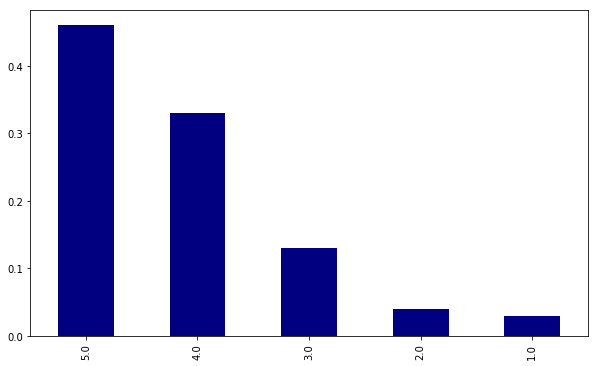

In [93]:
newplot = (combined_hotel_reviews.rating.value_counts()/combined_hotel_reviews.rating.count()).round(2)
print(newplot)
newplot.plot.bar(figsize=(10, 6), color='navy')

In [116]:
combined_hotel_reviews1.head()

,uid,rating,hid
0,12177,5.0,407
1,12177,5.0,407
2,32619,5.0,407
3,12264,5.0,407
4,12264,5.0,407


In [117]:
combined_hotel_reviews1.shape

(57706, 3)

In [69]:
combined_hotel_reviews1 = combined_hotel_reviews.groupby(['hid', 'uid'])

In [71]:
import numpy as np

In [72]:
grouped_rating = combined_hotel_reviews1[['rating']].agg(np.mean).round(2)
grouped_rating.head()

rating
hid uid          
0   2286      4.0
1   18661     4.0
2   10461     5.0
    16121     5.0
    34748     4.0

In [73]:
grouped_rating.shape

(57001, 1)

In [74]:
grouped_rating.reset_index(inplace=True)

In [75]:
grouped_rating.columns

Index(['hid', 'uid', 'rating'], dtype='object')

In [179]:
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore,  BaselineOnly, CoClustering
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import dump
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [77]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(grouped_rating[['uid', 'hid', 'rating']], reader)

In [78]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.956258,9.041795,0.417898
SVD,0.960347,3.020561,0.247785
BaselineOnly,0.960787,0.232597,0.191847
KNNBaseline,0.962389,43.821965,0.593082
KNNBasic,1.008804,43.333673,0.852668
CoClustering,1.072723,6.633984,0.192176
KNNWithZScore,1.106655,49.831109,0.827667
SlopeOne,1.107283,2.402773,0.233943
KNNWithMeans,1.109585,48.969638,0.872696


In [84]:
grid_search_result = pd.DataFrame(columns=['algorithm', 'param_grid', 'best_rmse_score', 'best_params', 'test_prediction_rmse'])

In [100]:
print('Using SVDpp')

n_epochs = [23, 25, 27]
lr_all = [0.0075, 0.01, 0.0125]
reg_all = [0.1, 0.2, 0.3]

param_grid = {'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all}
gs1 = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5)
gs1.fit(data)

print(gs1.best_score['rmse'])
print(gs1.best_params['rmse'])

trainset, testset = train_test_split(data, test_size=.25)
algo = gs1.best_estimator['rmse']
predictions1 = algo.fit(trainset).test(testset)
accuracy.rmse(predictions1)

grid_search_result = grid_search_result.append({'algorithm':'SVDpp', 'param_grid':{'n_epochs':n_epochs, 'lr_all':lr_all, 'reg_all':reg_all}, 'best_rmse_score':gs1.best_score['rmse'], 'best_params':gs1.best_params['rmse'], 'test_prediction_rmse':accuracy.rmse(predictions1)}, ignore_index=True)

Using SVDpp
0.9479587082216628
{'n_epochs': 23, 'lr_all': 0.01, 'reg_all': 0.3}
RMSE: 0.9626
RMSE: 0.9626


In [81]:
trainset, testset = train_test_split(data, test_size=.25)
algo = gs1.best_estimator['rmse']
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.9587


0.9587458939992112

In [115]:
print('Using SVD')

n_epochs = [13, 15, 17]
lr_all = [0.015, 0.02, 0.025]
reg_all = [0.25, 0.3, 0.35]

param_grid = {'n_epochs':n_epochs, 'lr_all':lr_all, 'reg_all':reg_all}
gs2 = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs2.fit(data)

print(gs2.best_score['rmse'])
print(gs2.best_params['rmse'])

algo = gs2.best_estimator['rmse']
predictions2 = algo.fit(trainset).test(testset)
accuracy.rmse(predictions2)

grid_search_result = grid_search_result.append({'algorithm':'SVD', 'param_grid':{'n_epochs':n_epochs, 'lr_all':lr_all, 'reg_all':reg_all}, 'best_rmse_score':gs2.best_score['rmse'], 'best_params':gs2.best_params['rmse'], 'test_prediction_rmse':accuracy.rmse(predictions2)}, ignore_index=True)

Using SVD
0.948445393077899
{'n_epochs': 17, 'lr_all': 0.015, 'reg_all': 0.25}
RMSE: 0.9624
RMSE: 0.9624


In [159]:
grid_search_result.head(10)

,algorithm,param_grid,best_rmse_score,best_params,test_prediction_rmse
0,SVDpp,"{'n_epochs': [15, 20, 25], 'lr_all': [0.005, 0...",0.949632,"{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.2}",0.949039
1,SVD,"{'n_epochs': [20, 30, 40], 'lr_all': [0.005, 0...",0.950114,"{'n_epochs': 20, 'lr_all': 0.015, 'reg_all': 0.3}",0.948726
2,BaselineOnly,"{'method': ['als', 'sgd'], 'reg': [1, 2], 'k':...",0.956279,"{'bsl_options': {'method': 'als', 'reg': 1, 'k...",0.957669
3,KNNBaseline,{},0.956899,"{'bsl_options': {'method': 'als', 'reg': 1}, '...",0.957669
4,SVDpp,"{'n_epochs': [20, 25, 30], 'lr_all': [0.0075, ...",0.950034,"{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.2}",0.933289
5,SVD,"{'n_epochs': [15, 20, 25], 'lr_all': [0.01, 0....",0.949666,"{'n_epochs': 15, 'lr_all': 0.02, 'reg_all': 0.3}",0.933123
6,SVDpp,"{'n_epochs': [23, 25, 27], 'lr_all': [0.0075, ...",0.947959,"{'n_epochs': 23, 'lr_all': 0.01, 'reg_all': 0.3}",0.962562
7,SVD,"{'n_epochs': [13, 15, 17], 'lr_all': [0.015, 0...",0.948445,"{'n_epochs': 17, 'lr_all': 0.015, 'reg_all': 0...",0.962401


In [176]:
algo = gs2.best_estimator['rmse']
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.9513


0.9513152304879025

In [113]:
grid_search_result = grid_search_result.replace({'param_grid','{}'}, "[{'method':['als', 'sgd'], 'reg':[1, 2]}, 'k':[2, 3], 'sim_options': {'name':['msd', 'cosine'], 'min_support':[1, 5], 'user_based':[False]}]")

In [89]:
print('Baseline Only Using ALS and SGD')

method = ['als', 'sgd']
reg = [1, 2]
k = [1, 2, 3]

param_grid = {'bsl_options': {'method':method, 'reg':reg, 'k': k}}
gs3 = GridSearchCV(BaselineOnly, param_grid, measures=['rmse', 'mae'], cv=5)
gs3.fit(data)

print(gs3.best_score['rmse'])
print(gs3.best_params['rmse'])

algo = gs3.best_estimator['rmse']
predictions3 = algo.fit(trainset).test(testset)
accuracy.rmse(predictions3)

grid_search_result = grid_search_result.append({'algorithm':'BaselineOnly', 'param_grid':{'method':method, 'reg':reg, 'k': k}, 'best_rmse_score':gs3.best_score['rmse'], 'best_params':gs3.best_params['rmse'], 'test_prediction_rmse':accuracy.rmse(predictions3)}, ignore_index=True)

Baseline Only Using ALS and SGD
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using sgd...
Estimat

In [172]:
algo = gs3.best_estimator['rmse']
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9673


0.9673084780495192

In [90]:
print('KNN Baseline Using ALS and SGD')

method = ['als', 'sgd']
reg = [1, 2]
k = [2, 3]
name = ['msd', 'cosine']
min_support = [1, 5, 10]
user_based = [False]

param_grid = {'bsl_options': {'method':method, 'reg':reg}, 'k':k, 'sim_options': {'name':name, 'min_support':min_support, 'user_based':user_based}}
gs4 = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=5)
gs4.fit(data)

print(gs4.best_score['rmse'])
print(gs4.best_params['rmse'])

algo = gs4.best_estimator['rmse']
predictions4 = algo.fit(trainset).test(testset)
accuracy.rmse(predictions4)

grid_search_result = grid_search_result.append({'algorithm':'KNNBaseline', 'param_grid':{'method':method, 'reg':reg}, 'k':k, 'sim_options': {'name':name, 'min_support':min_support, 'user_based':user_based}}, 'best_rmse_score':gs4.best_score['rmse'], 'best_params':gs4.best_params['rmse'], 'test_prediction_rmse':accuracy.rmse(predictions4)}, ignore_index=True)

KNN Baseline Only Using ALS and SGD
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als.

In [178]:
algo = gs4.best_estimator['rmse']
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9578


0.9578440721235078

In [ ]:
# Dump best algorithm and reload it.
file_name = os.path.expanduser('surprise_SVD_model')
dump.dump(file_name, algo=algo)
_, loaded_algo = dump.load(file_name)

In [181]:
import os

In [185]:
# Dump algorithm and reload it.
file_name = os.path.expanduser('surprise_SVD_model')
dump.dump(file_name, algo=algo)
_, loaded_algo = dump.load(file_name)

# We now ensure that the algo is still the same by checking the predictions.
predictions_loaded_algo = loaded_algo.test(trainset.build_testset())
# assert predictions2 == predictions_loaded_algo
# print('Predictions are the same')

In [186]:
def get_top_n(predictions, n=10):
    
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [187]:
# First train an SVD algorithm
data = Dataset.load_from_df(grouped_rating[['uid', 'hid', 'rating']], reader)
trainset = data.build_full_trainset()
algo = loaded_algo
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

KeyboardInterrupt: 